In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [3]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots

In [4]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [5]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
ϵ                      = 10               # perturbation
nev                    = 10
t_initial              = minimum(Time)
t_end                  = t_initial+70     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [6]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_end + param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

138.769329 seconds (91.92 M allocations: 5.215 GiB, 0.91% gc time)


In [10]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata);

In [11]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

1675.145752 seconds (111.05 M allocations: 8.897 GiB, 0.08% gc time)


In [12]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

  3.328821 seconds (9.21 M allocations: 592.635 MiB, 2.83% gc time)


In [13]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [14]:
# solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

  1.624473 seconds (4.18 M allocations: 297.980 MiB, 12.41% gc time)
  0.398447 seconds (65.91 k allocations: 98.541 MiB, 40.59% gc time)
  0.559546 seconds (298 allocations: 245.238 MiB, 2.78% gc time)
  0.231041 seconds (297 allocations: 94.908 MiB, 2.04% gc time)
  0.553493 seconds (298 allocations: 260.332 MiB, 0.78% gc time)
  0.552689 seconds (298 allocations: 261.256 MiB, 0.79% gc time)
  0.227612 seconds (297 allocations: 94.938 MiB, 1.37% gc time)
  0.222416 seconds (295 allocations: 98.130 MiB)
  0.234408 seconds (299 allocations: 103.115 MiB, 1.85% gc time)
  0.222821 seconds (295 allocations: 94.938 MiB)


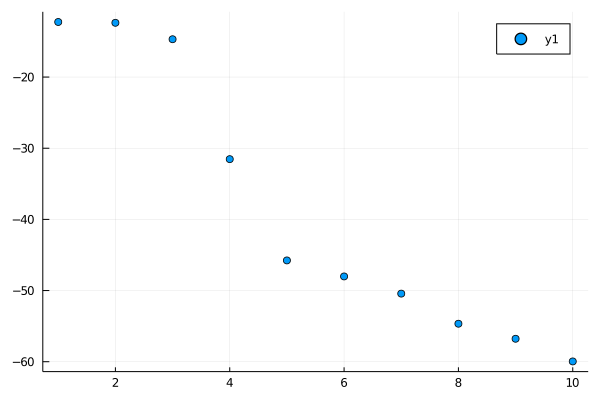

In [15]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [16]:
nev = 4
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
u_dot = u_dot[:,1:nev]
λ_dot = λ_dot[1:nev];

In [17]:
for i in 1:nev
    print("exact ev"*string(i)*": "*string(λϵ[i])*
        "\t predicted ev"*string(i)*": "*string(λ₀[i] + ϵ*λ_dot[i])*
        "\t relative error: "*string(abs(λ₀[i] + ϵ*λ_dot[i] - λϵ[i])/abs(λϵ[i]))*"\n")
end

exact ev1: -13.292040434469525	 predicted ev1: -14.379508459242182	 relative error: 0.08181347552574281
exact ev2: -14.973986006554236	 predicted ev2: -13.892062291657094	 relative error: 0.072253554559459
exact ev3: -17.311779522564517	 predicted ev3: -16.20489898377071	 relative error: 0.06393799882623714
exact ev4: -43.46622579288996	 predicted ev4: -40.303875014863024	 relative error: 0.07275420675112351


In [18]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmins =     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,]
cmaxs =     -cmins
cmins_lr =  [-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,-0.2, -0.2, -0.2, -0.2,]
cmaxs_lr =  -cmins_lr;

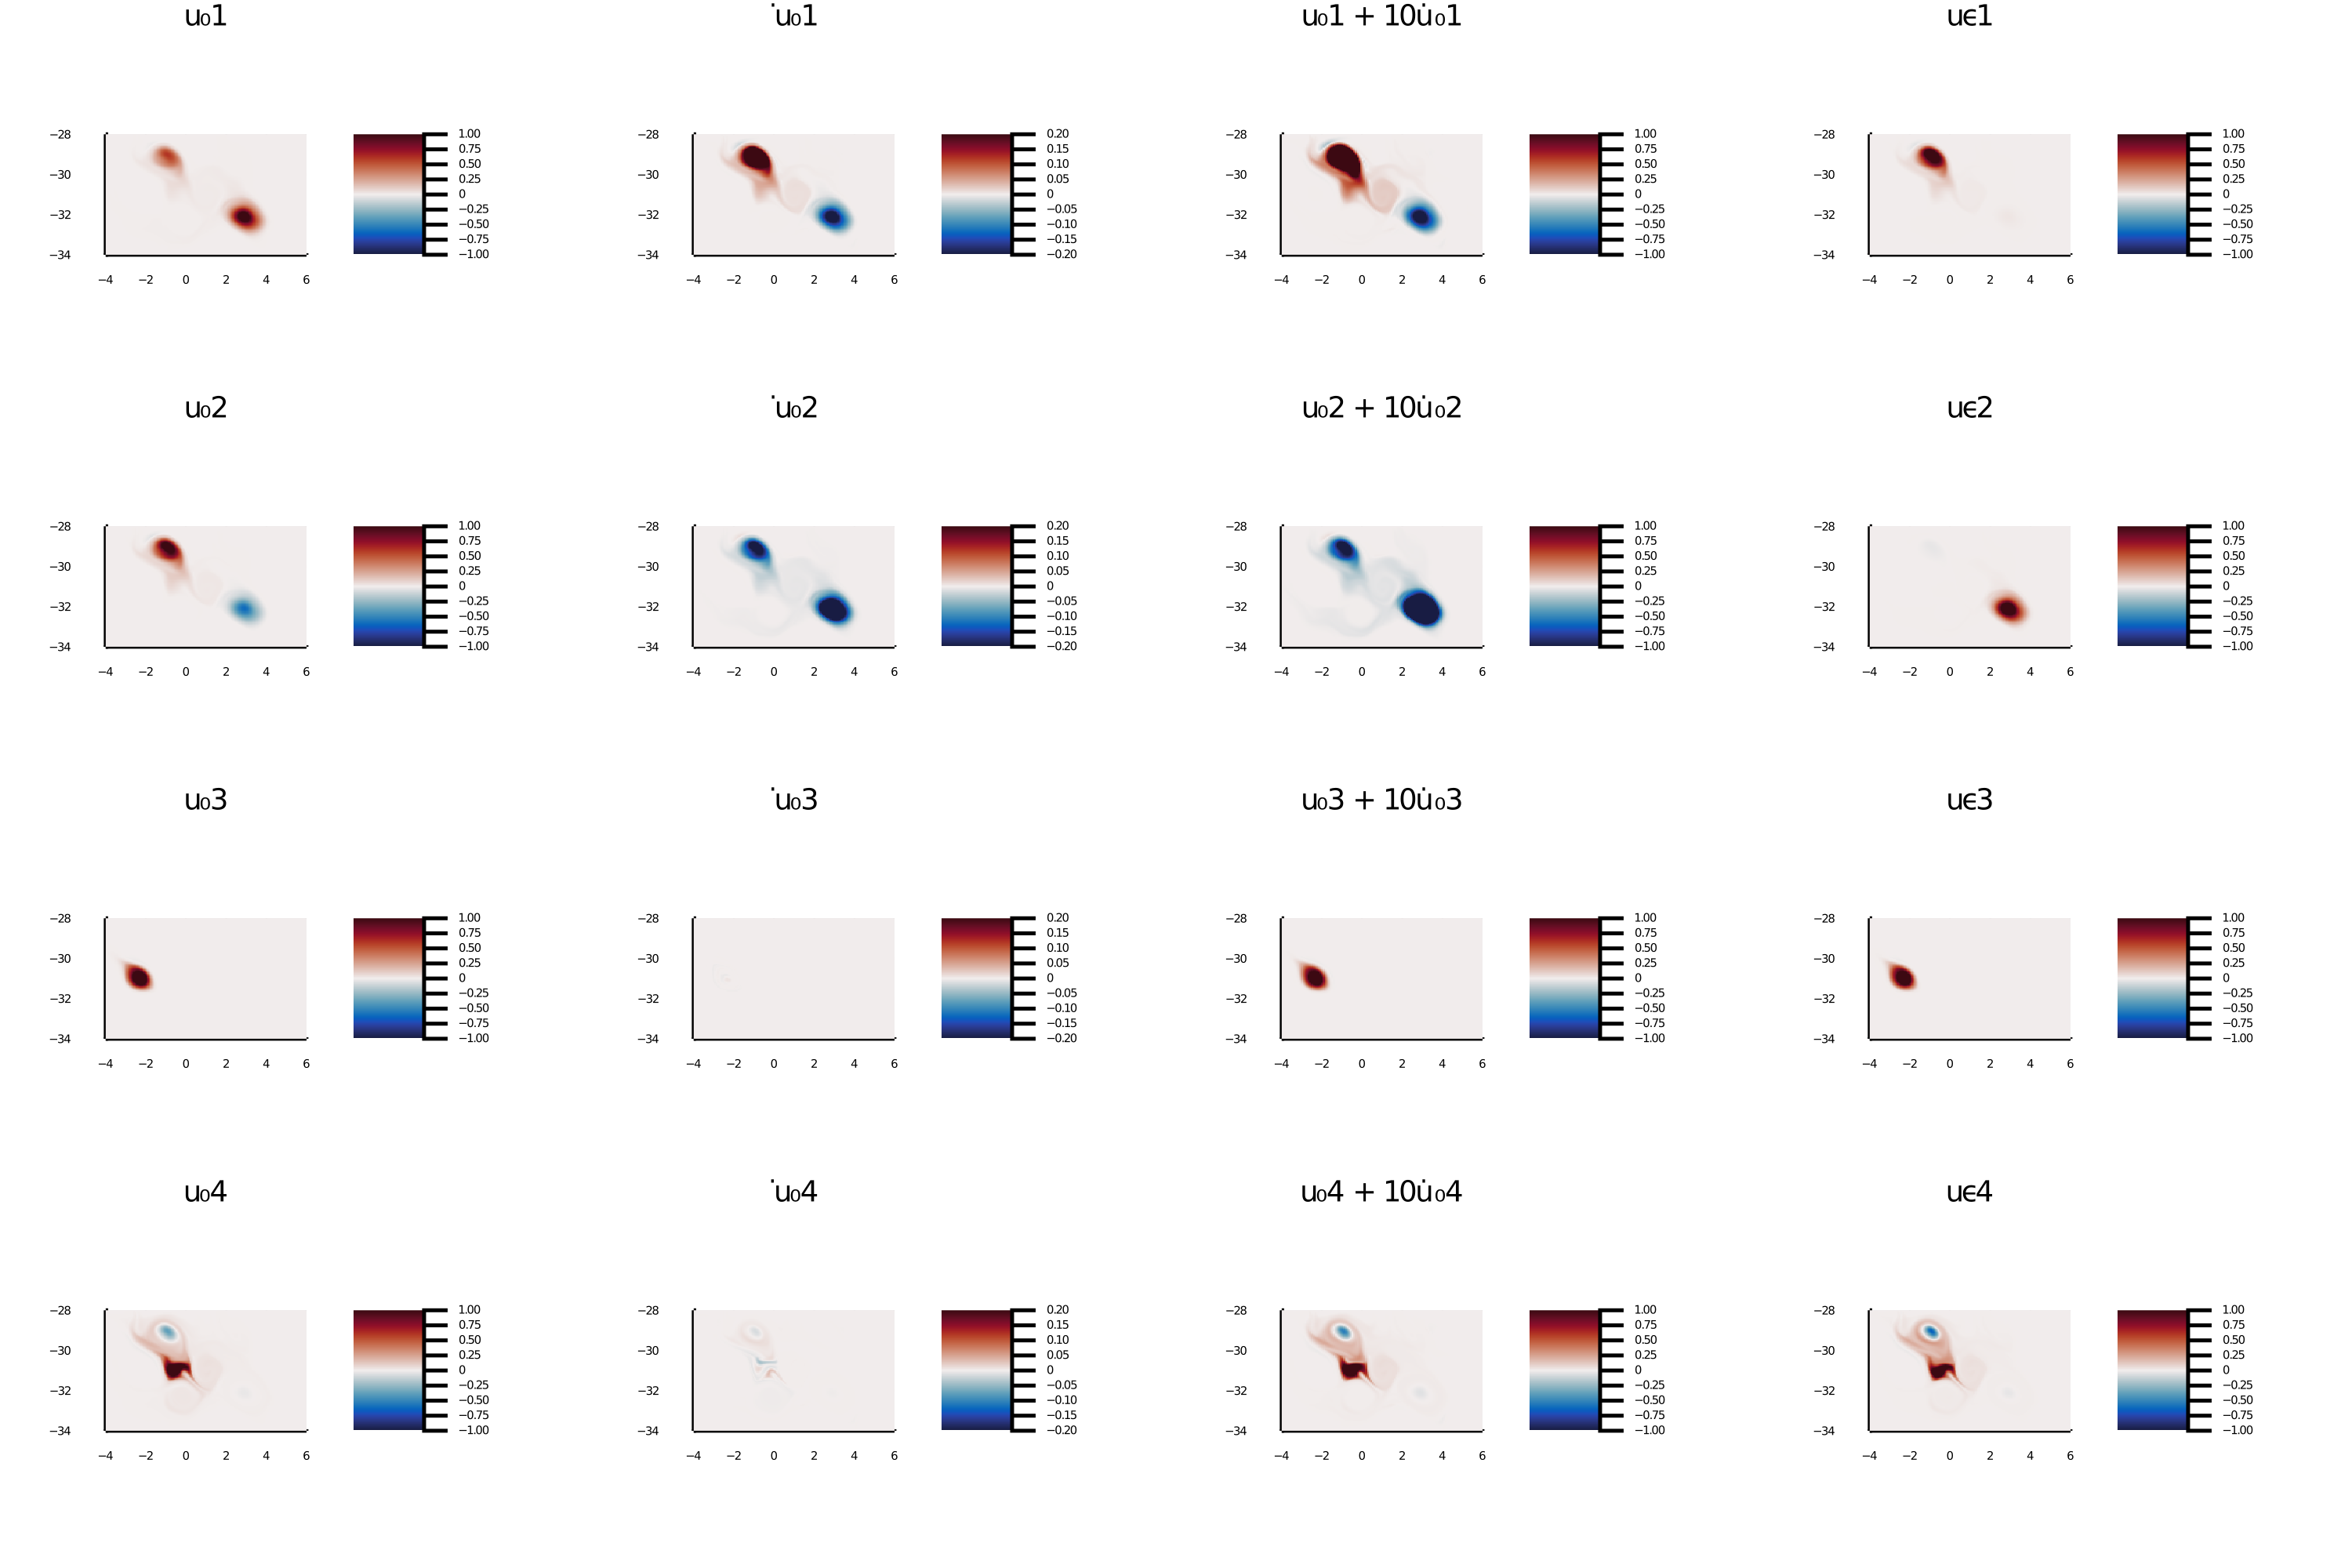

In [19]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  lat_resolution, grid_resolution, bdata=bdata,
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [20]:
#limit ourselves to one ev for plotting etc.
ev = 1

1

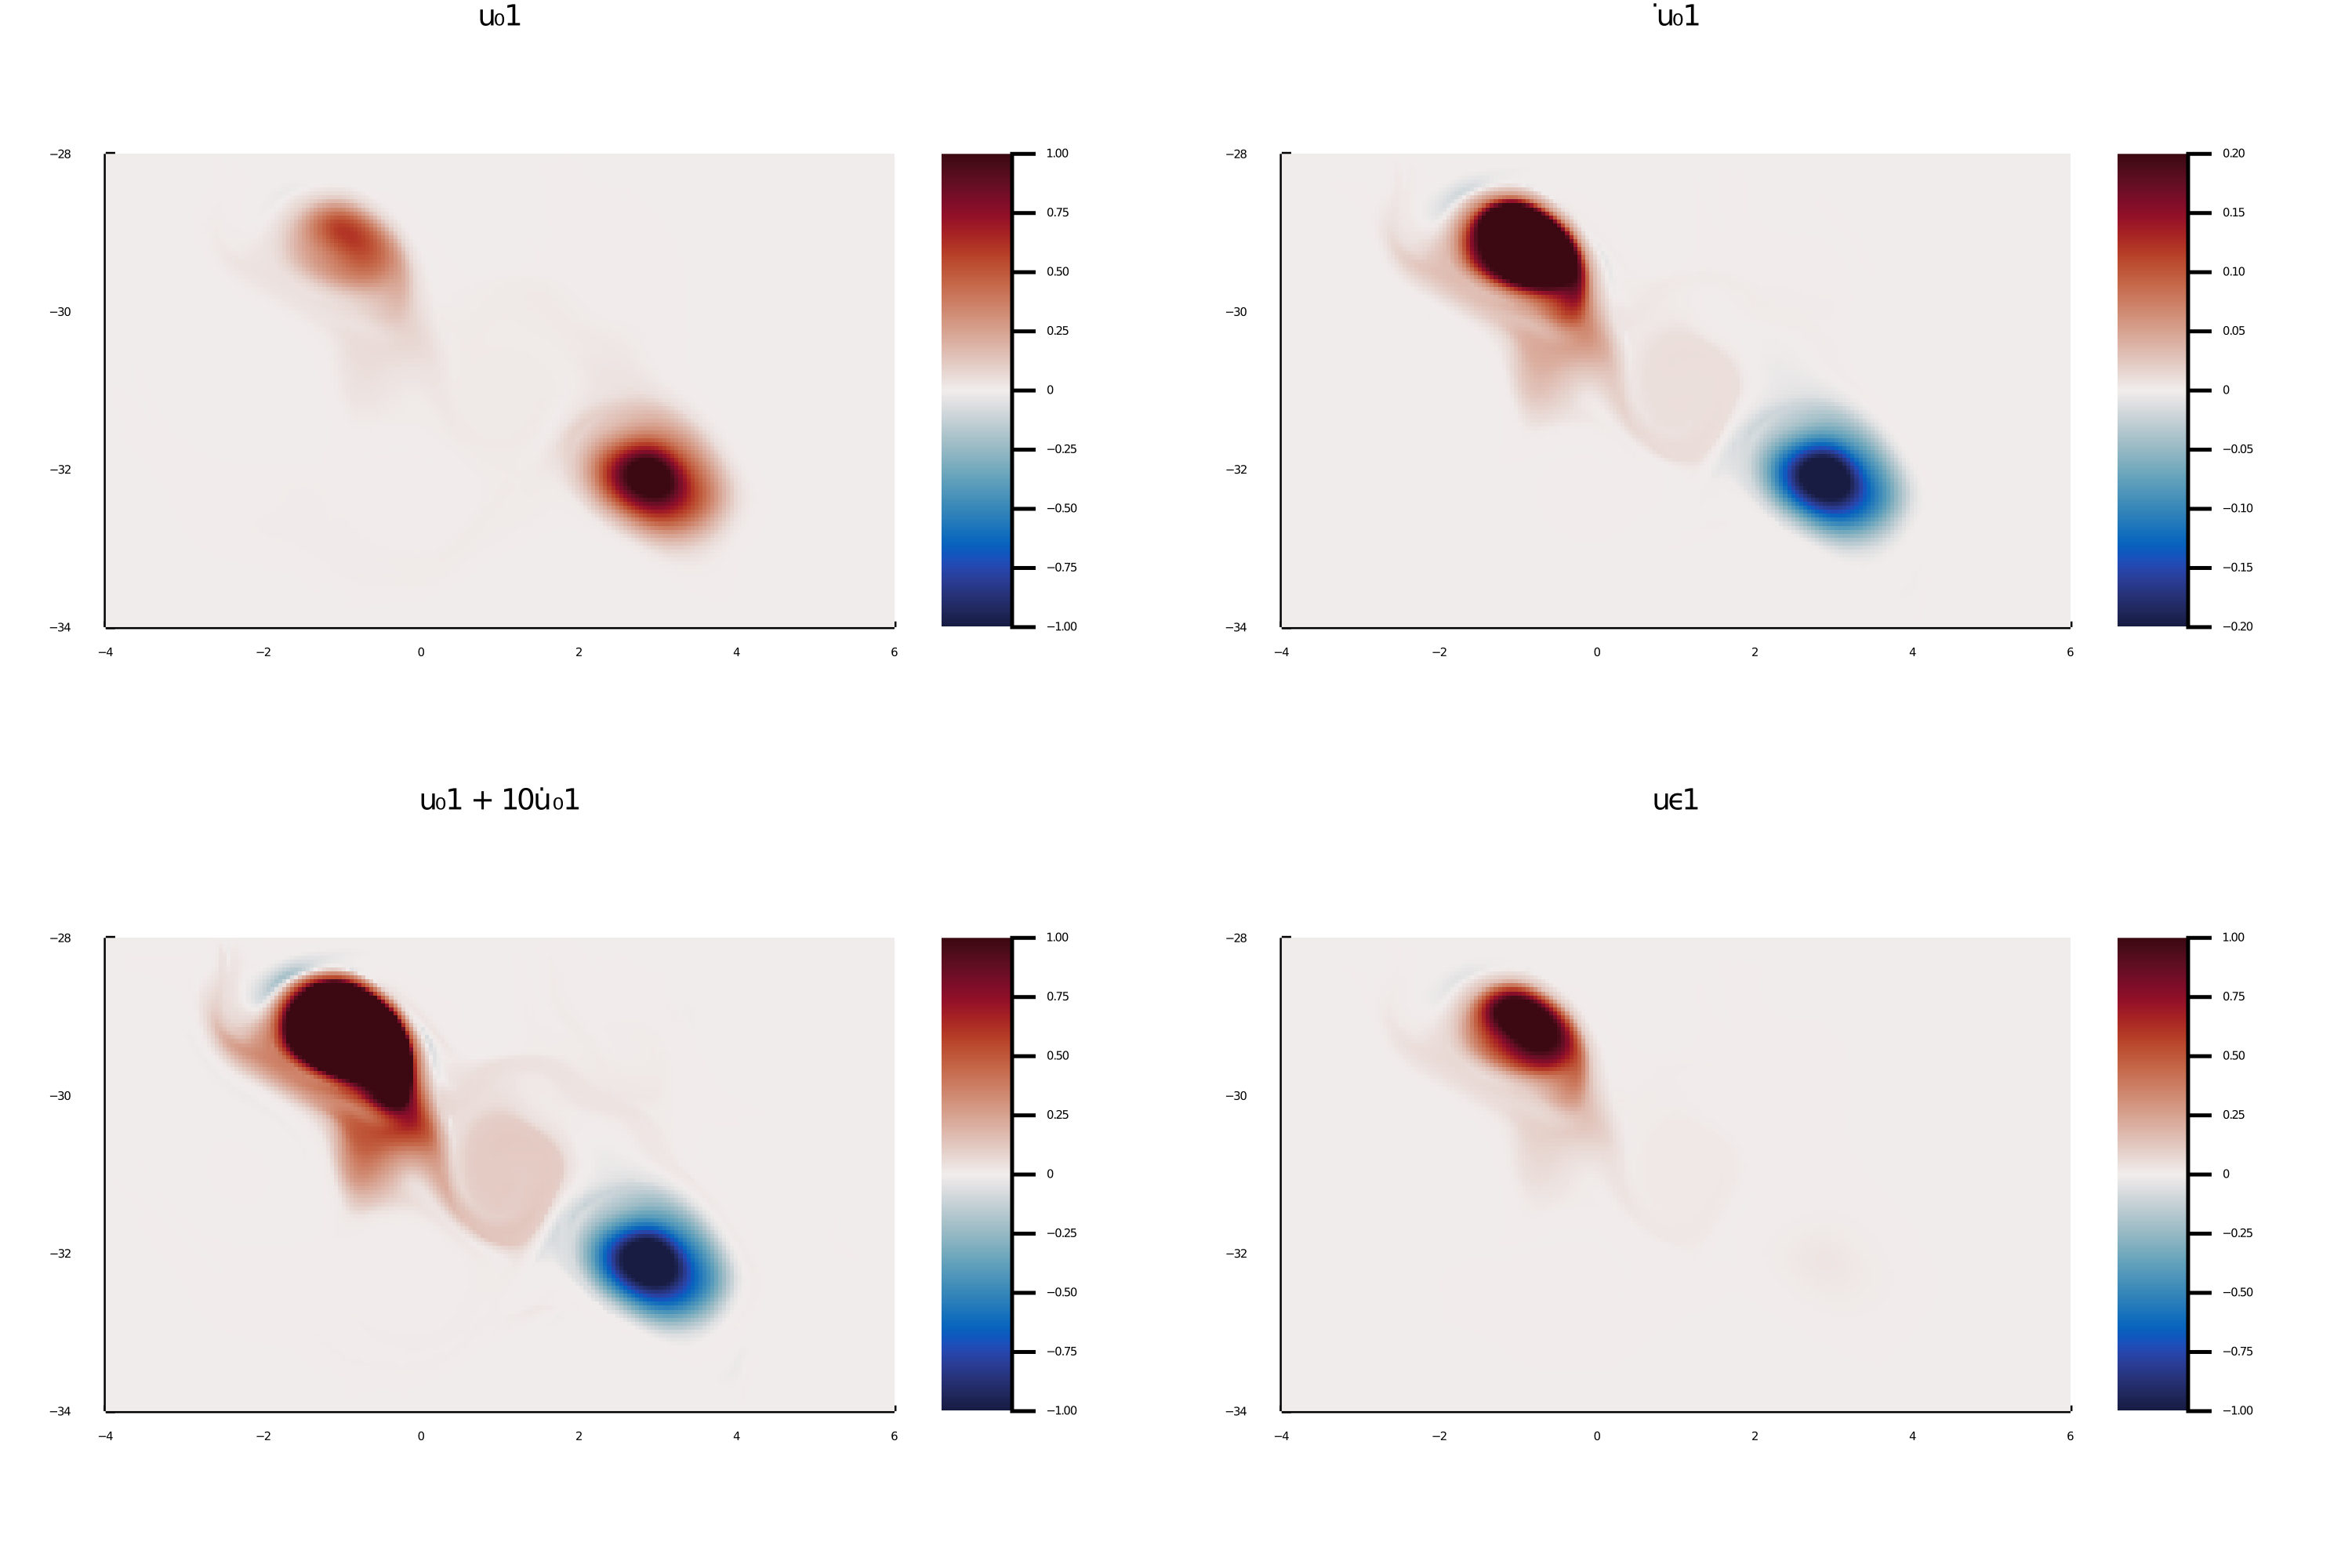

In [21]:
plots = []
push!(plots,plot_u(ctx, u₀[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="u₀"*string(ev), 
            colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u_dot[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="̇u₀"*string(ev), 
    colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="u₀"*string(ev)*" + $(ϵ)u̇ ₀"*string(ev), 
colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, uϵ[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="uϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

## Contour Plots

In [22]:
using Contour

In [23]:
import Main.CoherentStructures:dynamic_cheeger_value
dynamic_cheeger_value(c) = dynamic_cheeger_value(ctx,c,x->T(x,0);tolerance=1e-10)

dynamic_cheeger_value (generic function with 2 methods)

In [24]:
# Just here to compare with the matlab function

function isClosed(curve)
   return Main.CoherentStructures.closeCurve(ctx,curve,tolerance=1e-10) == curve
end

function dynamic_cheeger_value_matlab(curve)
    image_curve   = Main.CoherentStructures.apply2curve(x->T(x,ϵ),curve)
    
    if !isClosed(curve) || !isClosed(image_curve)
        return Inf
    end
    
    return 0.5(Main.CoherentStructures.getLength(curve)/Main.CoherentStructures.getEuclideanArea(ctx,curve,tolerance=1e-10) +
        Main.CoherentStructures.getLength(image_curve)/Main.CoherentStructures.getEuclideanArea(ctx,image_curve,tolerance=1e-10))
end

dynamic_cheeger_value_matlab (generic function with 1 method)

In [25]:
# resoultion for the levelset methods (default should be 'nothing', that way the grid resolution is used)
x_resolution = 500
y_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*x_resolution));

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.018831310778844045)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0175846136982676)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.016337916617691153)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.005117642892503127)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.00387094581192668)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.002624248731350233)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0013775516507737856)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.00013085457019733837)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: "

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08090445566727174)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08215115274784818)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08339784982842463)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08464454690900107)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08589124398957752)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08713794107015396)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08838463815073042)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08963133523130687)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.090878032311

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17191334254935237)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17316003962992882)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17440673671050527)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17565343379108173)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17690013087165818)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1781468279522346)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17939352503281106)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1806402221133875)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.18188691919396

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26416892651200946)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2654156235925859)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26666232067316237)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2679090177537388)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2691557148343153)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2704024119148917)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2716491089954682)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2728958060760446)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.27414250315662103)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.3551778133940901)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.35642451047466656)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.357671207555243)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.35891790463581946)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.3601646017163959)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.36141129879697237)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.3626579958775488)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.3639046929581253)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.3651513900387017)


┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.44618670027617074)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4474333973567472)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.44868009443732365)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4499267915179001)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.45117348859847656)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.452420185679053)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.45366688275962946)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4549135798402059)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.45616027692078237

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5371955871582514)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5384422842388279)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5396889813194043)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5409356783999808)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5421823754805573)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5434290725611337)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.54467576964171)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5459224667222865)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.547169163802863)
└ @ M

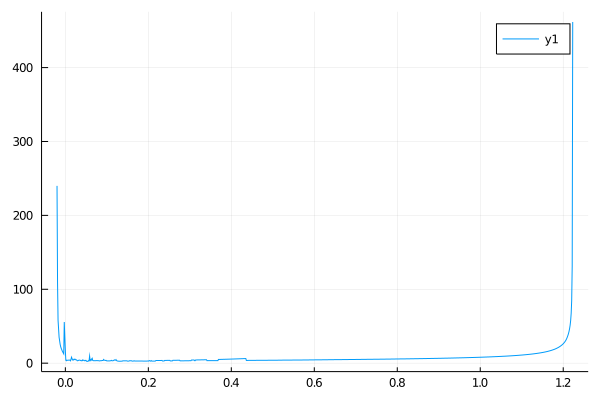

In [26]:
minU = minimum(u₀[:,ev])
maxU = maximum(u₀[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0003003003003003003)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0006006006006006006)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0009009009009009009)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0012012012012012011)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0015015015015015015)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0018018018018018018)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002102102102102102)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002402402402402

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.021621621621621623)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.02192192192192192)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.022222222222222223)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.02252252252252252)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.022822822822822823)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.02312312312312312)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.023423423423423424)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.023723723723723725)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0240240

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04354354354354354)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04384384384384384)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.044144144144144144)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.044444444444444446)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04474474474474475)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04504504504504504)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.045345345345345345)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04564564564564565)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.045945945

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06516516516516517)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06546546546546547)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06576576576576576)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06606606606606606)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06636636636636636)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06666666666666667)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06696696696696697)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06726726726726727)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.067567567567

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0867867867867868)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08708708708708708)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08738738738738738)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08768768768768768)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08798798798798799)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08828828828828829)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08858858858858859)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08888888888888889)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0891891891891

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1087087087087087)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.109009009009009)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.10930930930930931)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.10960960960960961)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.10990990990990991)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11021021021021021)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11051051051051052)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11081081081081082)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.111111111111111

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13033033033033034)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13063063063063063)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13093093093093094)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13123123123123123)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13153153153153152)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13183183183183184)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13213213213213212)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.13243243243243244)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.132732732732

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15225225225225225)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15255255255255254)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15285285285285286)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15315315315315314)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15345345345345346)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15375375375375375)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15405405405405406)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.15435435435435435)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.154654654654

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17387387387387387)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17417417417417416)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17447447447447448)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17477477477477477)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17507507507507508)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17537537537537537)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17567567567567569)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.17597597597597597)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.176276276276

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.19579579579579579)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1960960960960961)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1963963963963964)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1966966966966967)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.196996996996997)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1972972972972973)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1975975975975976)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.19789789789789788)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1981981981981982)
└

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21771771771771772)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.218018018018018)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21831831831831833)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21861861861861862)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21891891891891893)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21921921921921922)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2195195195195195)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.21981981981981982)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.220120120120120

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23963963963963963)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.23993993993993995)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24024024024024024)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24054054054054055)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24084084084084084)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24114114114114113)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24144144144144145)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24174174174174173)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.242042042042

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2615615615615616)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2618618618618619)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26216216216216215)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26246246246246246)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2627627627627628)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26306306306306304)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26336336336336336)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.26366366366366367)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.263963963963964

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.28348348348348346)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.28378378378378377)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2840840840840841)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2843843843843844)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.28468468468468466)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.284984984984985)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2852852852852853)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2855855855855856)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.28588588588588587)

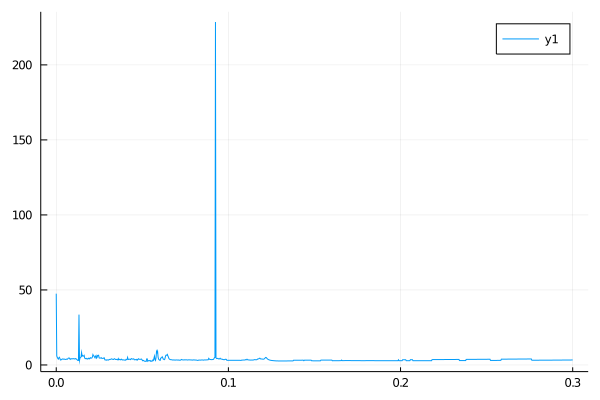

In [27]:
minU = 0
maxU = 0.3
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[1:end],values[1:end])
Plots.plot!(fmt=:png,dpi=100)

In [28]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0012253510295854593)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0024507020591709185)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.003676053088756378)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: 

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.040436583976320155)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04166193500590561)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04288728603549108)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04411263706507654)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08087316795264031)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08209851898222577)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08332387001181123)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.08454922104139669)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155


┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.12130975192896047)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.12253510295854593)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.12376045398813139)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.12498580501771685)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155


┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.16174633590528062)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.16297168693486608)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.16419703796445154)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.165422388994037)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ 

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.20218291988160078)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.20340827091118624)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2046336219407717)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.20585897297035716)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24261950385792094)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2438448548875064)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24507020591709186)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.24629555694667732)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2830560878342411)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.28428143886382656)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.285506789893412)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.2867321409229975)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Wa

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.3247180228401467)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.32594337386973216)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.32716872489931764)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.3283940759289031)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ 

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.3651546068164669)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.3663799578460523)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.3676053088756378)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.36883065990522323)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ W

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4092672438815434)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4104925949111289)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4117179459407143)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4129432969702998)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Wa

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.44970382785786356)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.45092917888744904)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4521545299170345)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.45337988094661996)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4901404118341837)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4913657628637692)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.49259111389335464)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4938164649229401)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ W

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5318023468400893)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5330276978696747)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5342530488992603)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5354783999288457)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Wa

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5746896328755804)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5759149839051658)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5771403349347514)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5783656859643368)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Wa

Dynamic Cheeger value:	2.5840119798262684
Levelset:		0.05514079633134567


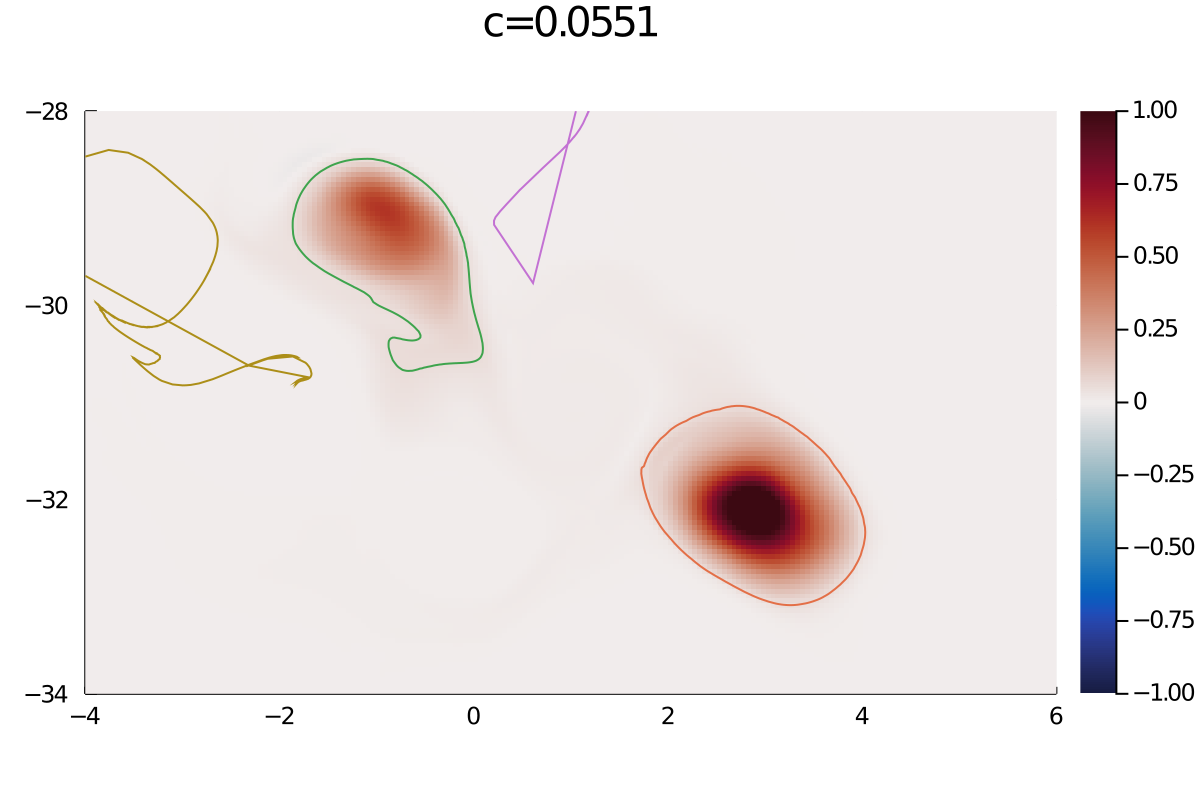

In [29]:
c_best = level(best_levelset)
plot_u(ctx, u₀[:,ev],  lon_resolution, lat_resolution, title="c=$(round(c_best,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false)

In [30]:
using PyCall
using PyPlot

In [31]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

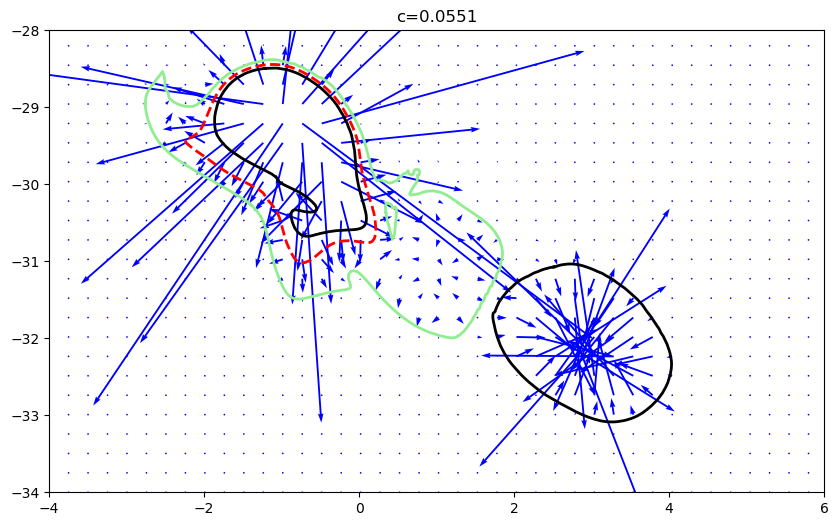

In [32]:
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev],bdata=bdata)...,ax,scale=1,step=5)
curves           = lines(get_levelset(ctx, u₀[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

## SEBA

In [33]:
using LinearAlgebra

In [34]:
softThreshold(u,μ) = sign.(u) .* max.(abs.(u) .- μ, 0)
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))
normalizeU(u,v) = u.*sign.(sum(v))/maximum(v*sign.(sum(v)));

In [35]:
μ = 0.99/grid_resolution;

In [36]:
@time S, R = SEBA(u₀,μ=μ,returnR=true,sort=false);

  1.509628 seconds (6.33 M allocations: 408.169 MiB, 5.06% gc time)


In [37]:
order = sortperm([-minimum(S[:,i]) for i in 1:nev]);

In [38]:
# This is the matrix we effectively multiply u₀ with
Rot = inv(qr(u₀).R)*R'

4×4 Array{Float64,2}:
 -0.0448974     0.0225156   -7.16775e-6  -0.00216948
  0.0226241     0.0447346   -1.30499e-5  -0.00364386
  5.98633e-7   -1.5865e-5   -0.0502409   -1.1152e-5
  0.000295454  -0.00419379   1.23972e-5  -0.0500027

In [39]:
S_dot = u_dot*Rot;

In [40]:
Sϵ, Rϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false);

In [41]:
S′ = Matrix(qr(u₀).Q)*R';

In [42]:
Sϵ′ = Matrix(qr(uϵ).Q)*Rϵ';

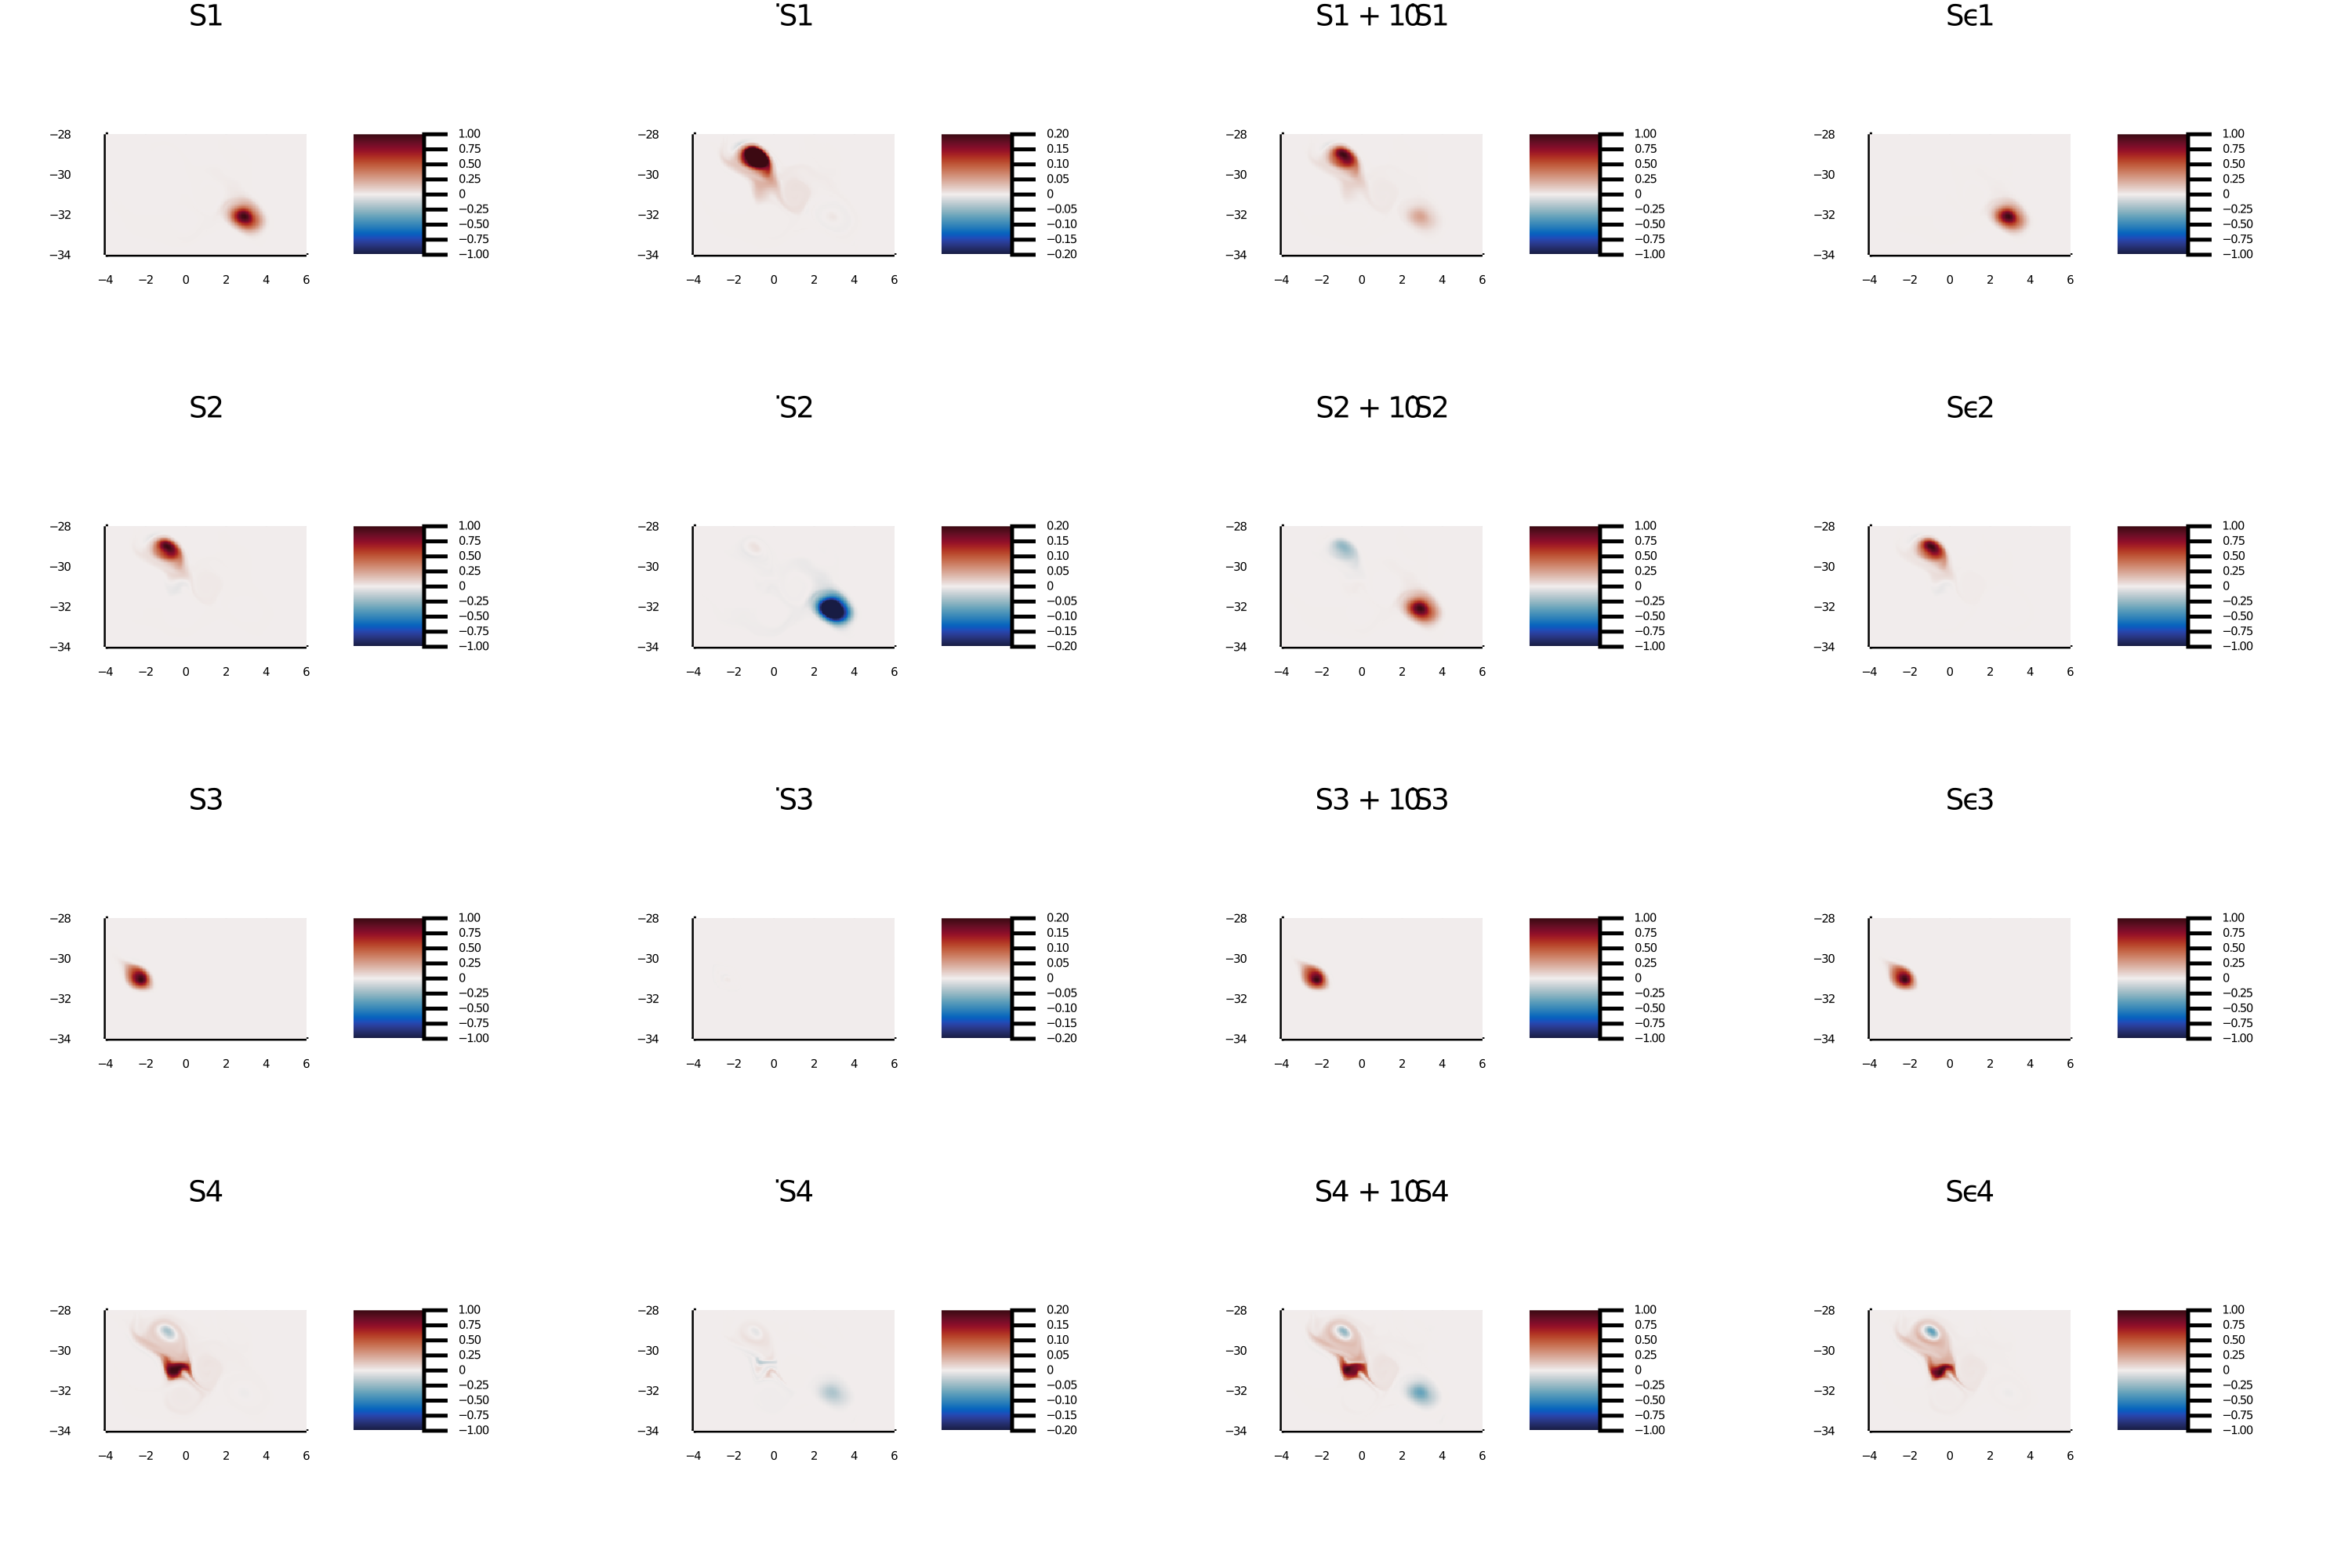

In [54]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, normalizeU(S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S′[:,i] + ϵ*S_dot[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

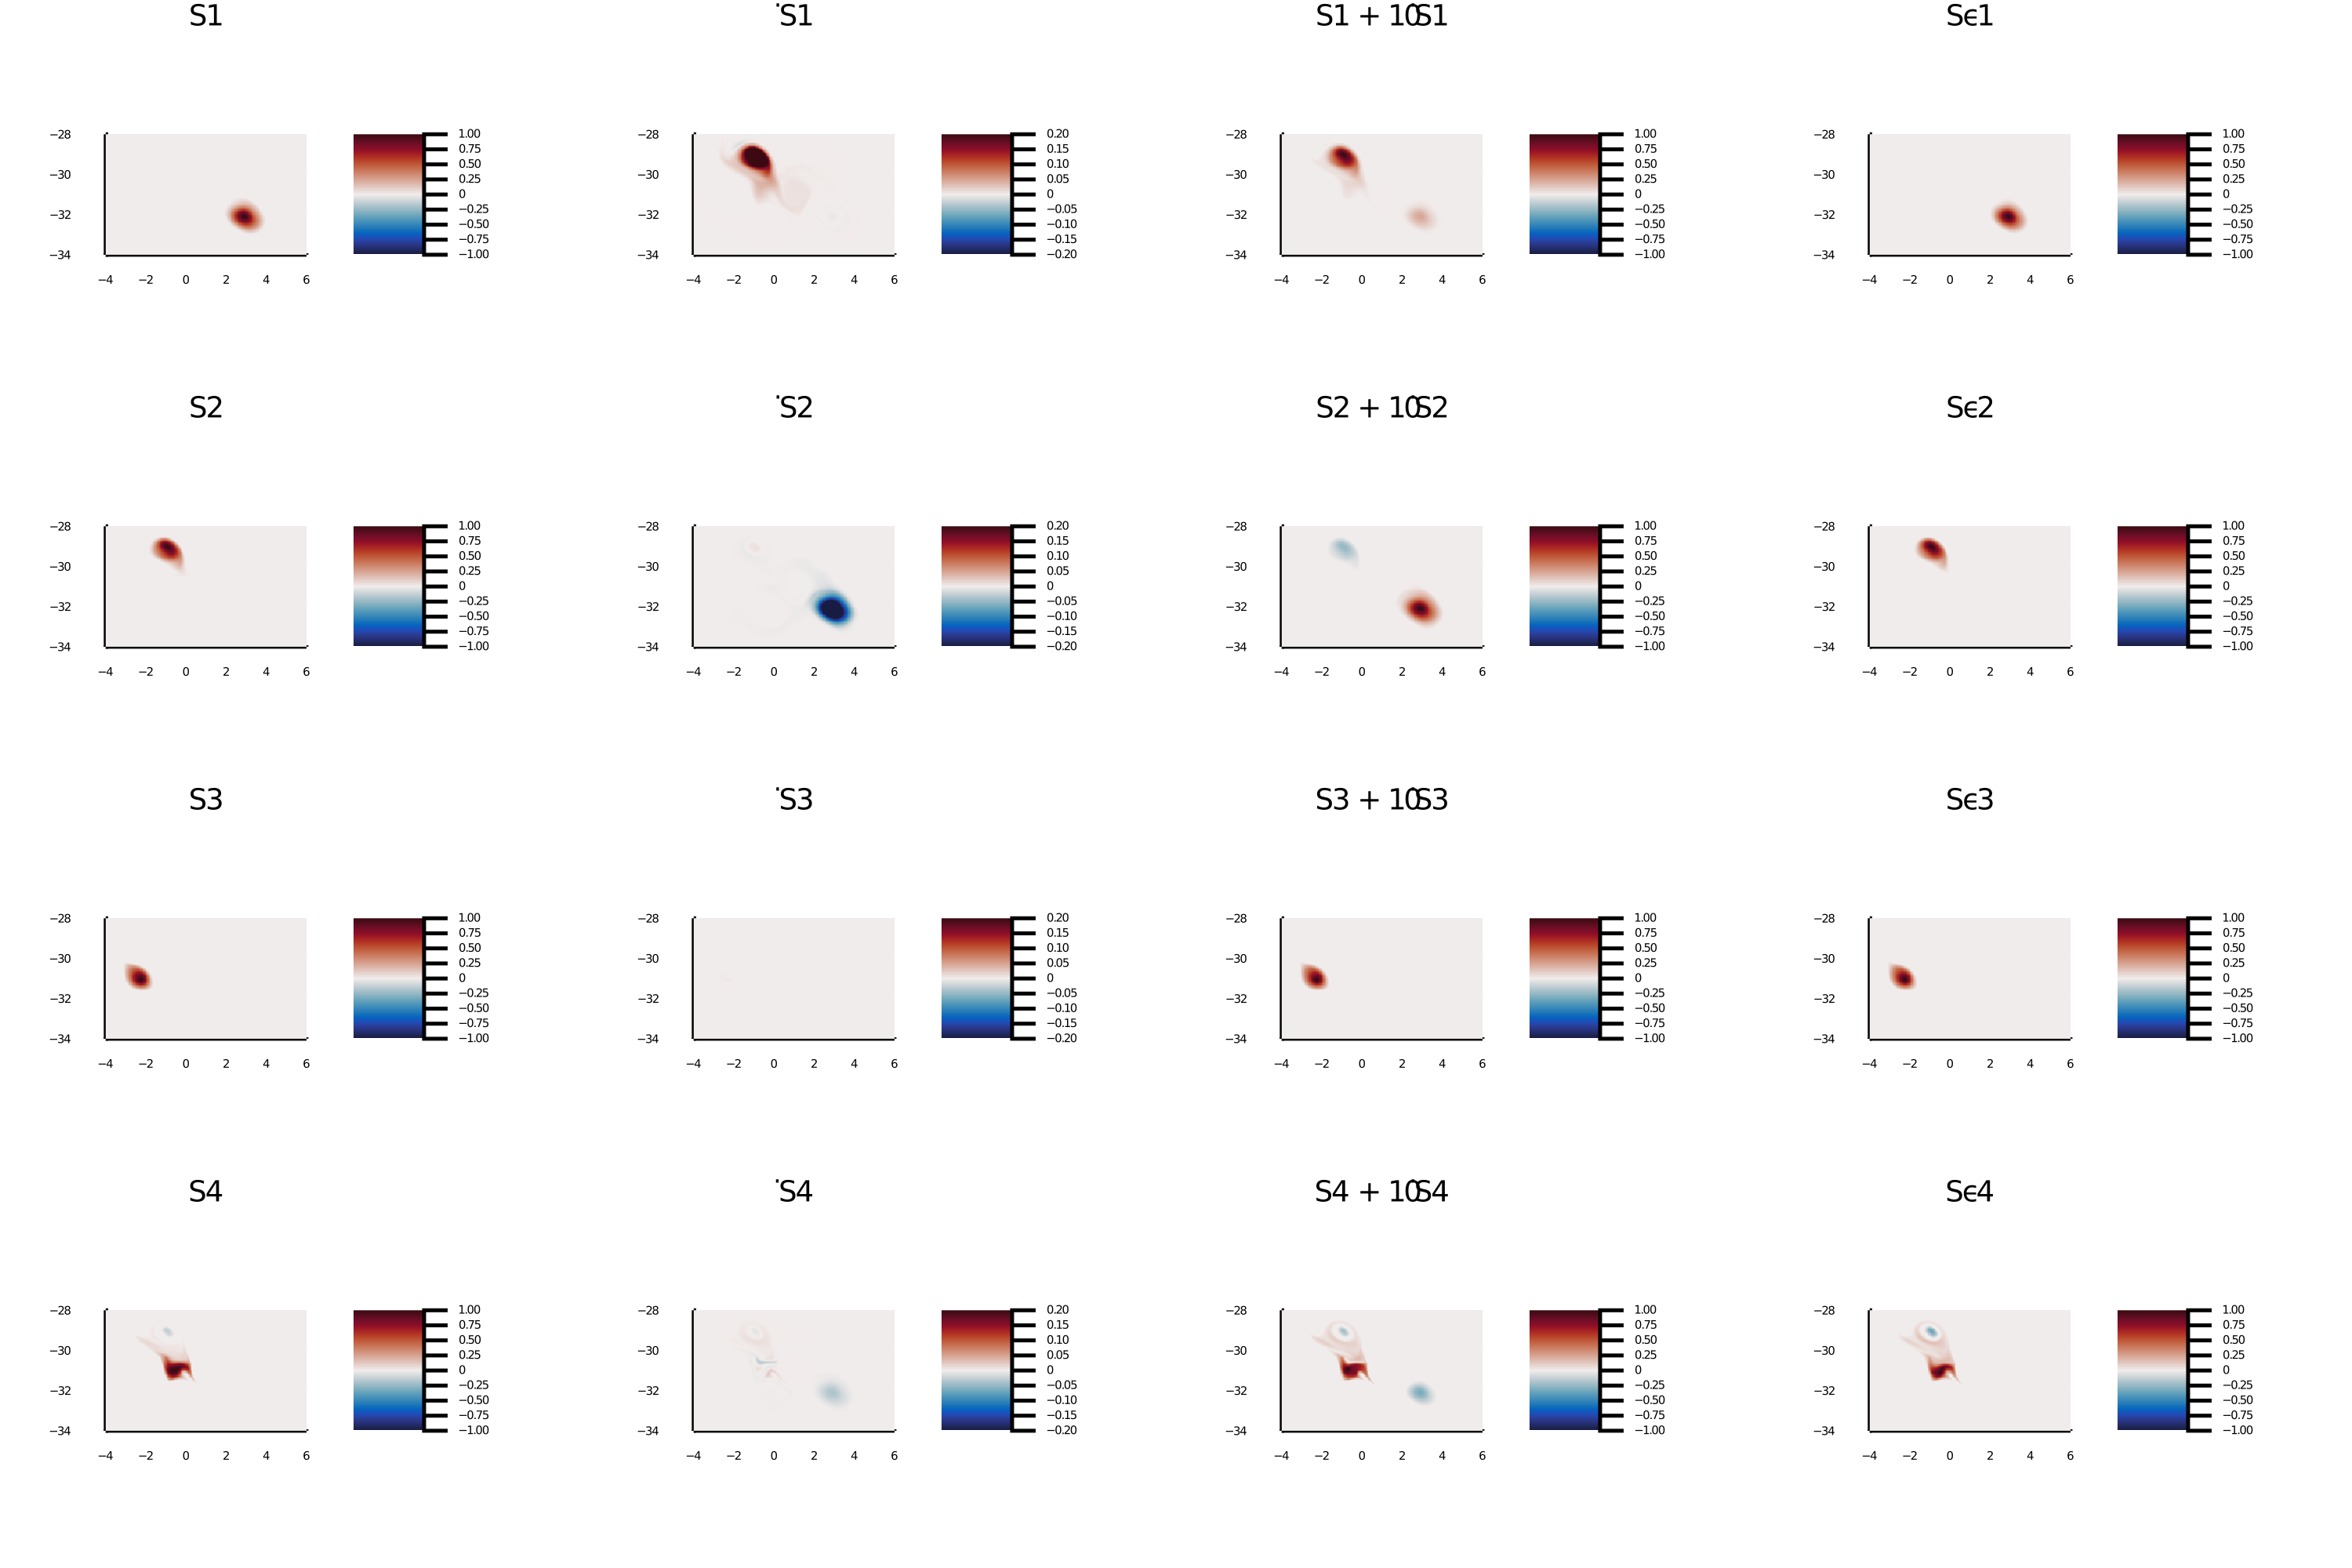

In [55]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,i] + ϵ*S_dot[:,i],μ)),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

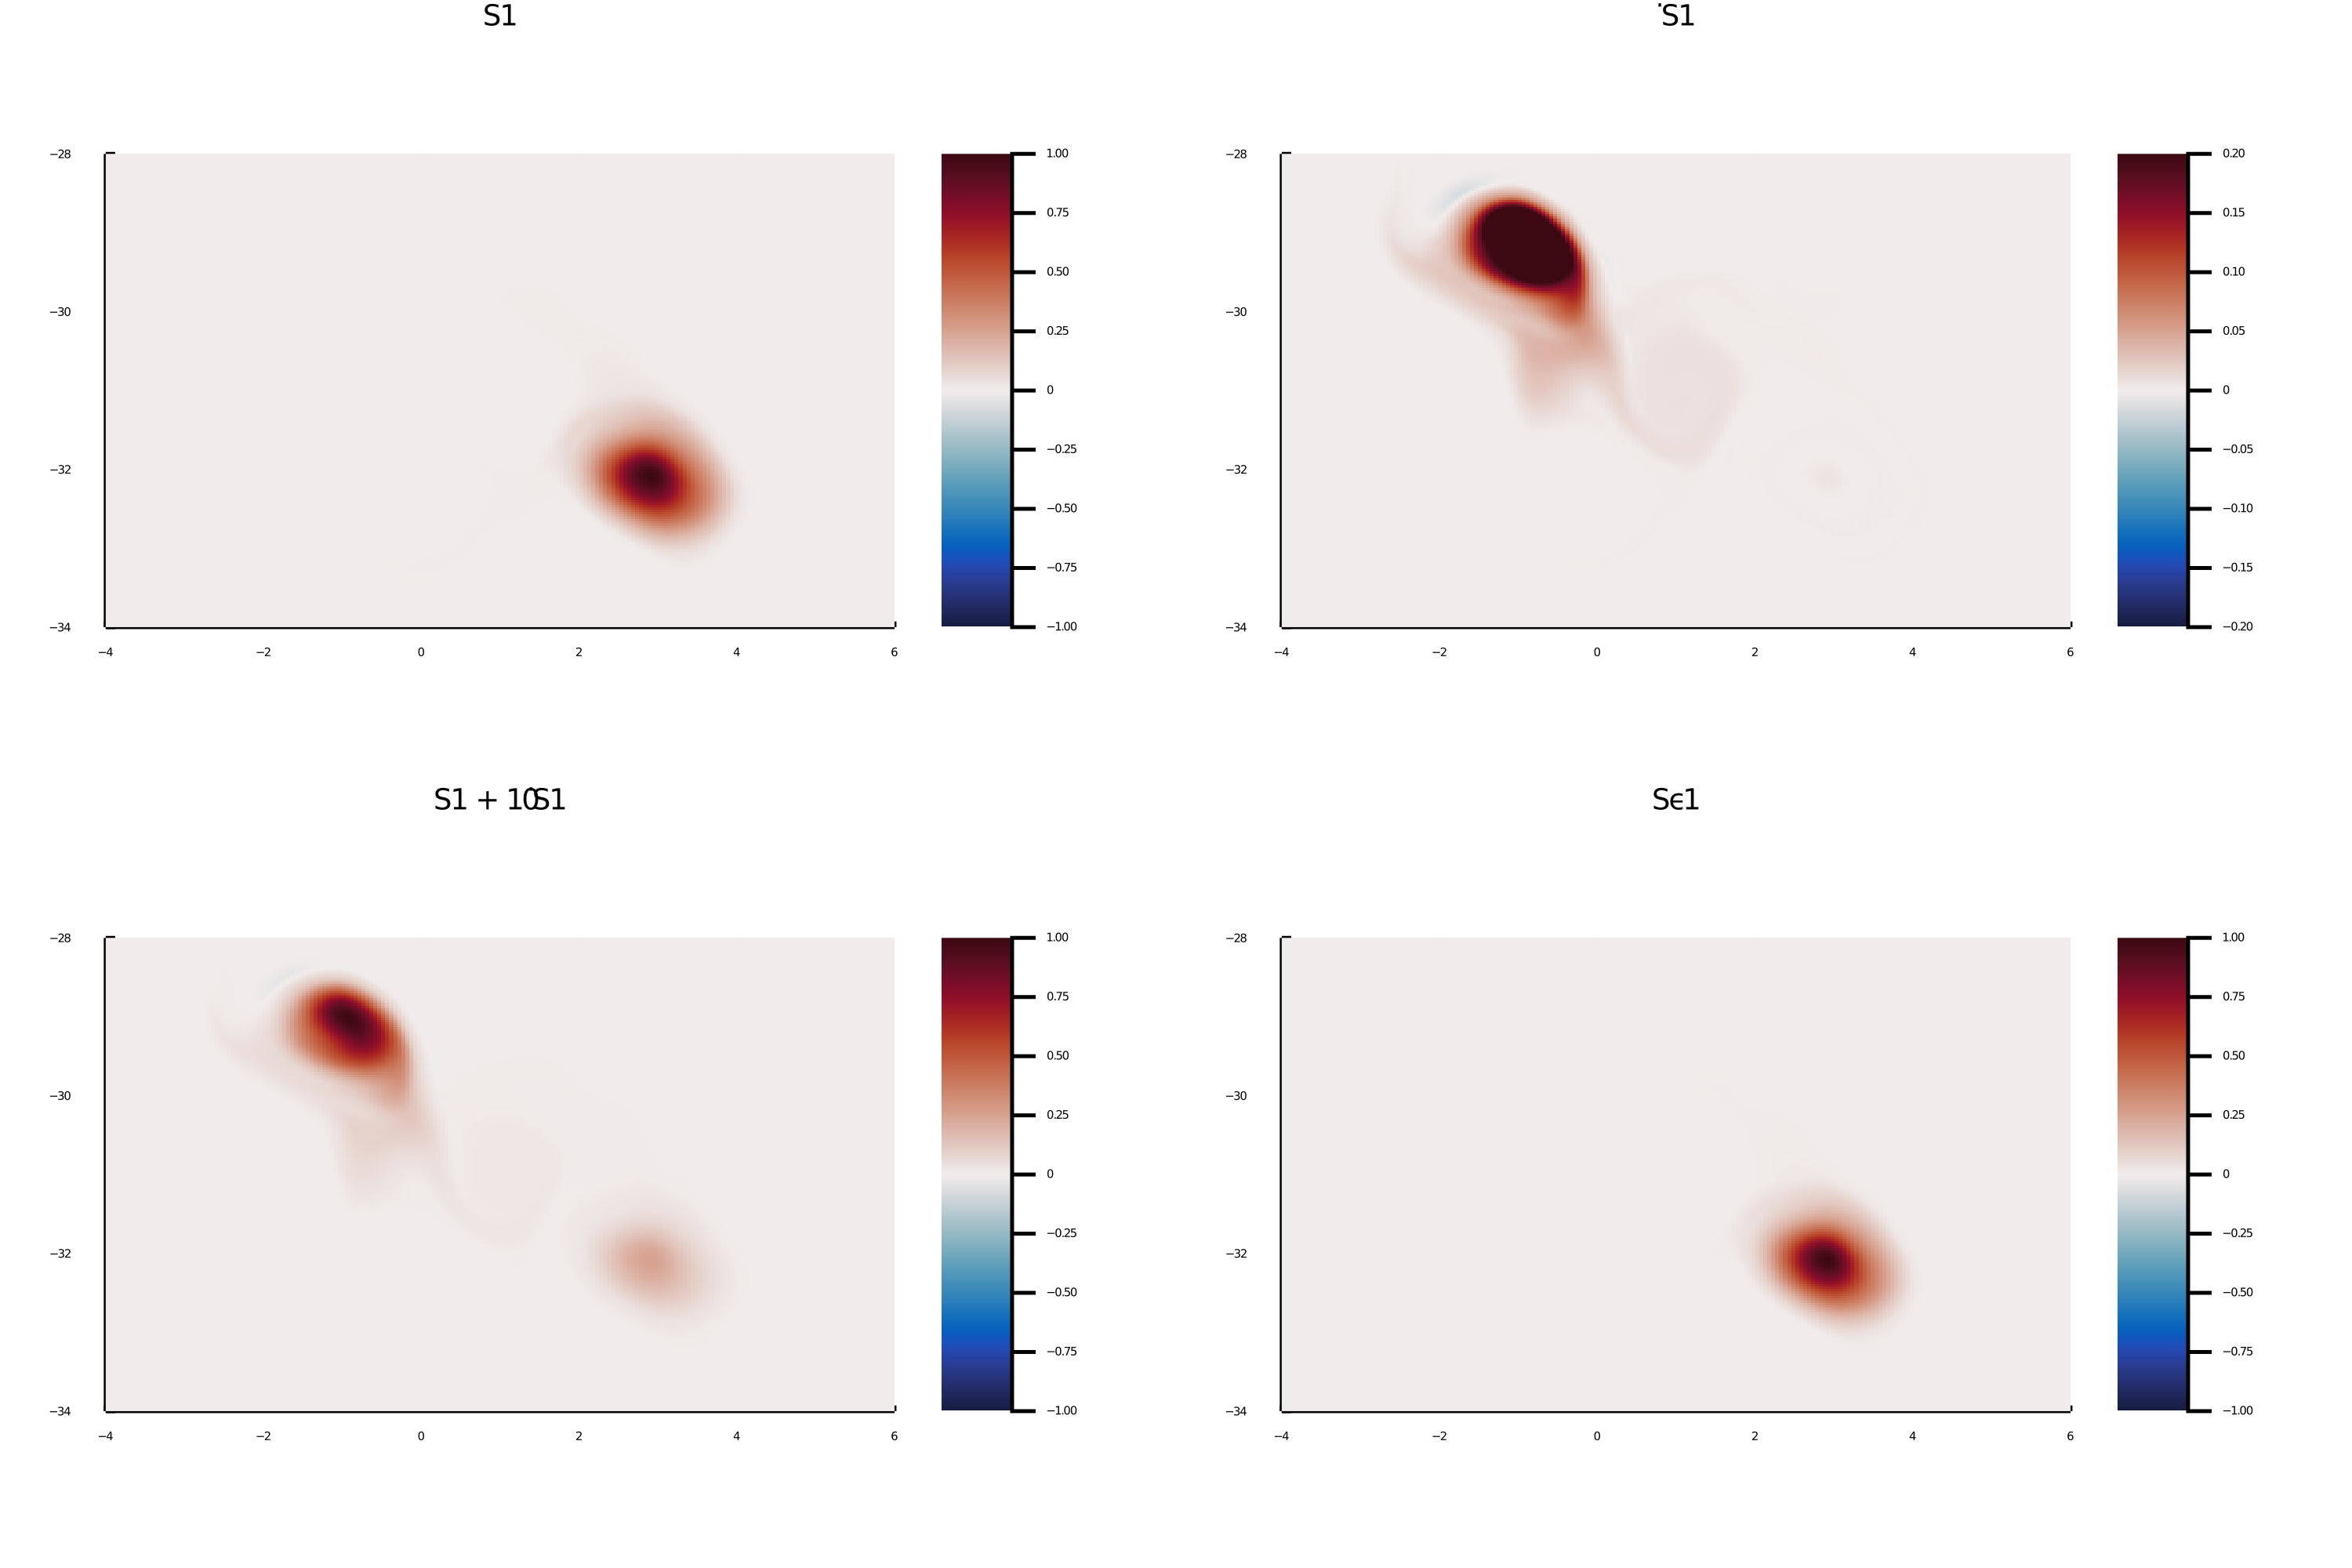

In [56]:
plots = []
push!(plots,plot_u(ctx, normalizeU(S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S′[:,ev] + ϵ*S_dot[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

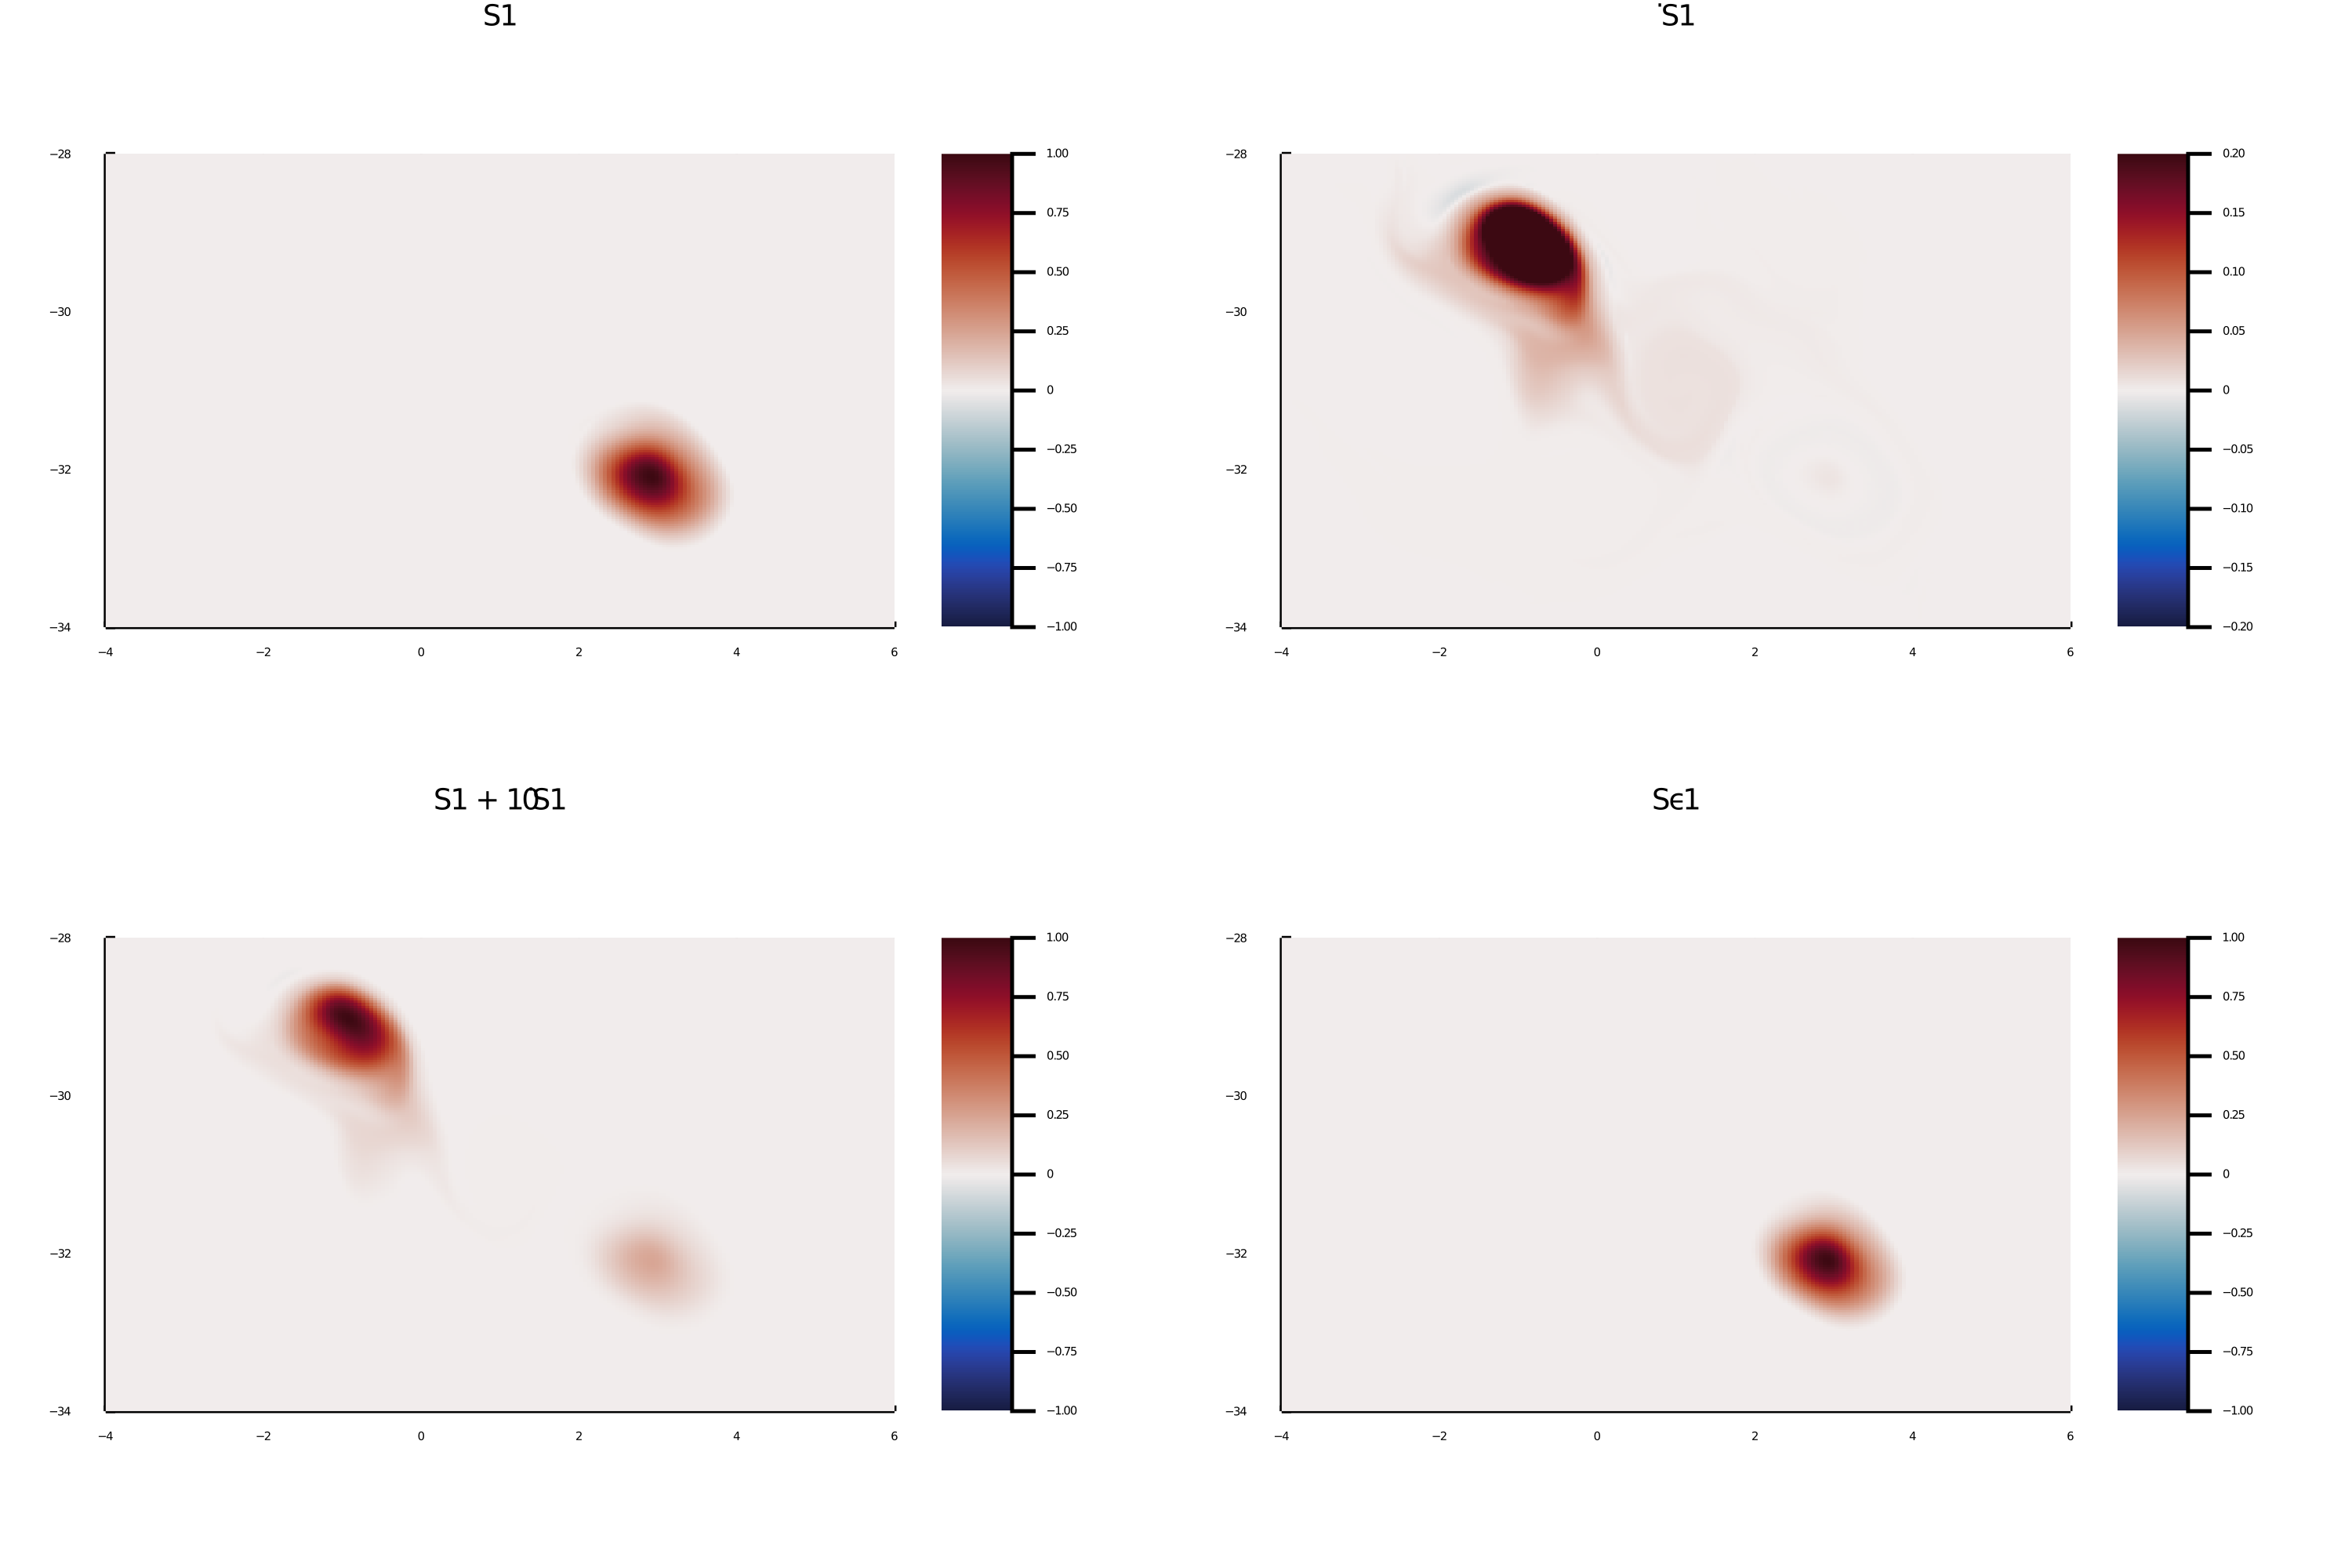

In [57]:
plots = []
push!(plots,plot_u(ctx, S[:,ev],  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, Sϵ[:,ev],  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.001001001001001001)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002002002002002002)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.004004004004004004)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.005005005005005005)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.006006006006006006)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.007007007007007007)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.008008008008008008)
└ @ Main In[47]:10


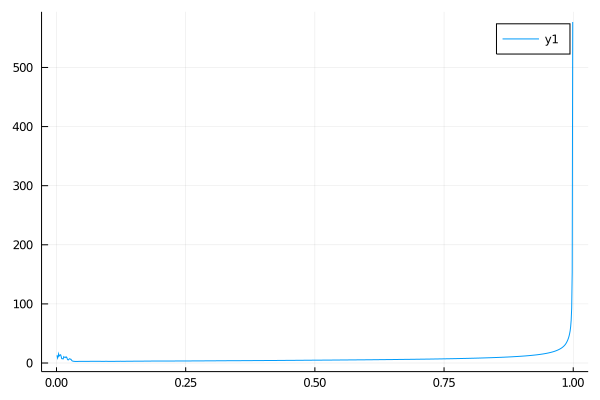

In [47]:
minU = minimum(S[:,ev])
maxU = maximum(S[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,S[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

In [48]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.001001001001001001)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002002002002002002)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.004004004004004004)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.005005005005005005)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:

Dynamic Cheeger value:	2.680130531424318
Levelset:		0.03803803803803804


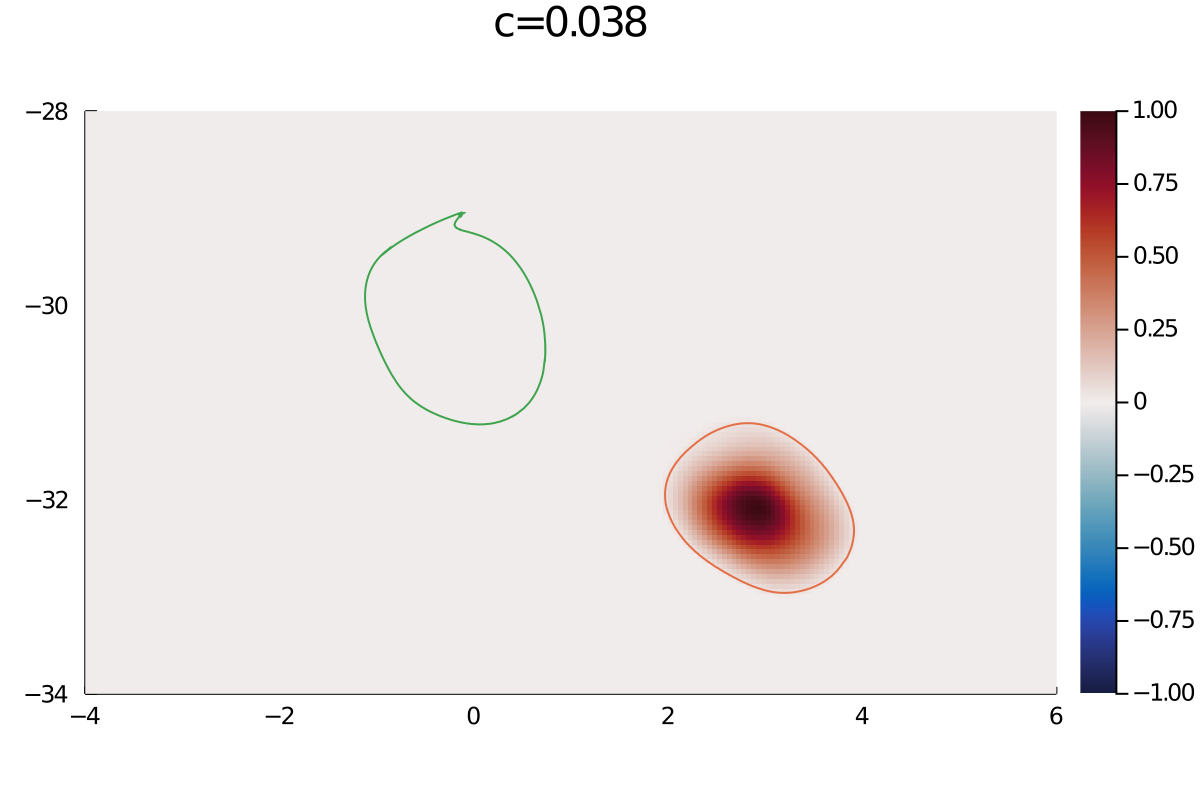

In [49]:
c_best = level(best_levelset)
plot_u(ctx, S[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="c=$(round(c_best,digits=4))",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value_matlab(curves[1])

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false)

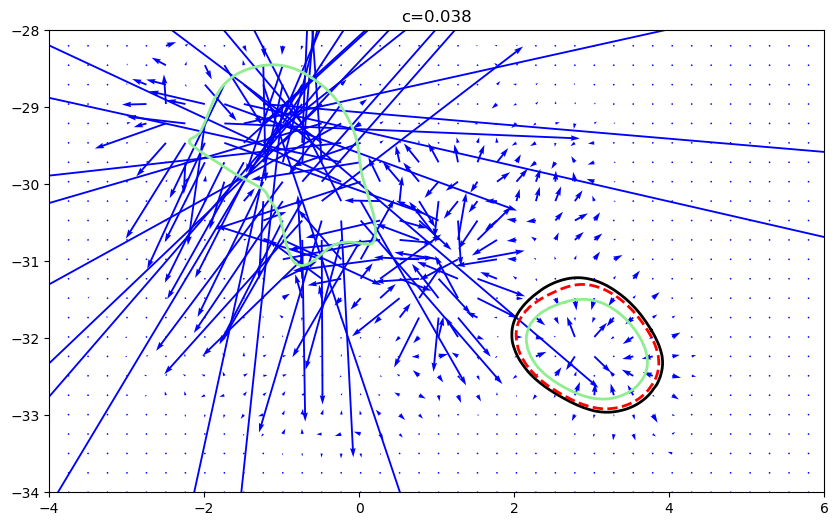

In [58]:
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
# this is not completely straightforward due to the nonlinearity of softThreshold!
plot_vectorfield(get_levelset_evolution(ctx,S′[:,ev],S_dot[:,ev],bdata=bdata)...,ax,scale=0.01,step=5)
curves           = lines(get_levelset(ctx, S[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev],c_best,
                x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),c_best,
                x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");